# [[ Model Training ]]
Train a CNN performing the image classification task on the MNIST dataset.
<img src=https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png width=500>

- Use PyTorch to train NN models.
- Do quantization aware training.
- Try different hyper-parameters and model architecures and see the effects.

# Define Models
The model we are constructing consists of 1 convolution layer and 3 fully connected (FC) layers.

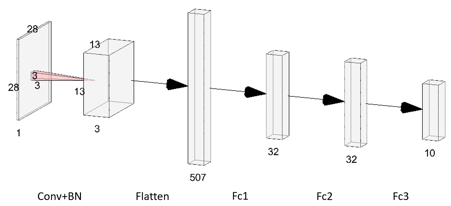

- The convolution layer has 3 output channels and the kernel size is 3, the stride is 2 and the padding is 0.
- A batch normalization (BN) layer is put after the convolution layer.
- Following the BN layer are three FC layers each with `numNeurons`, `numNeurons`, and 10 neurons, respectively.
- The activation function will be relu6, which is defined as $max(0,min(6,x))$.

We will define both the floating-point and quantized model with the above architecture.

## The quantized model

We then define the quantized model.
As will will implement quantization aware training, we have to first define the "fake quantization" operation, and then use it to define quantized layers.
Finally, we will use the quantized layers to build a 4-bit quantized model.

### Define "fake quantization" operation
Before define the quantized model, we first prepare the "fake quantization" operation. It quantization the input tensor and use straight through estimator when computing the gradient for back proagation.

- To define operations with customized gradient, we have to declare a calss inheriting `torch.autograd.Function` and implement the `forward` and `backward` functions.
- In `forward` we `quantize_tensor` and then `dequantize_tensor`. Since there are rounding and clamping in `quantize_tensor`, the values in the tenssor will be changed.
- In `backward`, we define how the gradient is computed. Since we use the straight through estimator, we don't need to modify the gradient and can directly return it.
- More information can be found [here](https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd).

In `quantize_tensor`, we basically rescale the values of the input tensor to $[-(2^{n-1}),2^{n-1}-1]$, where $n$ is the bitwidth for quantization, by multiplying the input tensor with `scale` shown in the following code.
- If `imposePow` is not specified:
    - `quantize_tensor` will compute the value of `scale`
    - Used when quantizing the weights and biases where we don't know the quantization scheme beforehand.
- If `imposePow` is specified:
    - `scale` is set according to `imposePow`
    - Used when quantizing the activations where we know the quantization scheme since we designed to use 4 bits for the interger part due to the relu6 activation function.

The `roundType` is relevant to the hardware implementation.
- For weights, we use `'round'` to get less quantization error.
- For activations, we use `'floor'` since the circuit we are going to used will truncate the LSBs of activations, which corresponds to take the floor operation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple
QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])
def quantize_tensor(x, num_bits=8, min_val=None, max_val=None,imposePow=None,roundType='round'):
    if imposePow is not None:
        scale=2**(-1*imposePow)
    else:
        if not min_val and not max_val: 
            min_val, max_val = x.min(), x.max()
        if min_val!=max_val:
            scale=2**(torch.ceil(torch.log2((max_val-min_val)/(2.**(num_bits)-1.))))
        else:
            scale=2**(torch.ceil(torch.log2((torch.tensor([1e-4]))/(2.**(num_bits)-1.))))
    zero_point=0
    q_x = zero_point + x / scale
    qmin = (2.**(num_bits-1))*(-1.)
    qmax = 2.**(num_bits-1) - 1.
    if roundType=='round':
        q_x.clamp_(qmin, qmax).round_()
    elif roundType=='floor':
        q_x.clamp_(qmin, qmax).floor_()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

class FakeQuantOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, w, numBits=4,imposePow=None,roundType='round'):
        x = quantize_tensor(w,num_bits=numBits,imposePow=imposePow,roundType=roundType)
        x = dequantize_tensor(x)
        return x
    @staticmethod
    def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None, None, None

### Define quantized layers
Then, we define two kinds of quantized layers that will be used to build our quantized model. To define a layer, we also create a calss inheriting `nn.Module` and define the inference behaviors in `forward` as we did when defining a mdoel.

The two types of layers are:
- `ConvBN_Quant`: A fused layer including convolution and batch normalization layers that supports quantization aware training (QAT).
- `Linear_Quant`: A linear layer that supports QAT.

In either layer type, we declare corresponding layer(s) offered in PyTorch as class members in `init`. When forwarding, we do the following steps:
1. extract the weights of the layer(s)
2. for `ConvBN_Quant`, fold the weights of conv and BN
3. apply `FakeQuantOp` on the weights
4. perform the `conv2d` or the `linear` operation with the quantized weights

- Since the quantization won't change the layer parameters, we effectively keep a floating-point copy of the weights.
- The inference is based on the quantized weights and so is the computation of gradient. 
- The only parameters are those in PyTorch native layers, so PyTorch will update the floating-point copy of weights.

The `ConvBN_Quant` offers the following helper functions:
- The `fold` function computes the weights after the `conv` and `bn` are folded and store the folded weights into the parameters of `conv`. Once it is folded, folding won't be performed again when forwarding.
- The `foldAndQuantize` function calls `fold` and quantizes the weights of `conv`.

The `Linear_Quant` offers the following helper function:
- The `quantize` function quantizes the weights of `linear`.

In [ ]:
class ConvBN_Quant(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, padding=1,nBits=8):
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.nBits=nBits
        super(ConvBN_Quant, self).__init__()
        self.conv = nn.Conv2d(in_planes,out_planes,kernel_size,stride,padding)
        self.bn = nn.BatchNorm2d(out_planes)
        self.folded = False
        self.quantized = False

    def forward(self,x):
        r=self.bn.weight.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        var=self.bn.running_var.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        
        if not self.folded:
            w=self.conv.weight*r/(torch.sqrt(var+self.bn.eps))
            b=(self.conv.bias-self.bn.running_mean)*self.bn.weight/(torch.sqrt(self.bn.running_var+self.bn.eps))+self.bn.bias
        else:
            w=self.conv.weight
            b=self.conv.bias
        if not self.quantized:        
            w=FakeQuantOp.apply(w,self.nBits)
            b=FakeQuantOp.apply(b,self.nBits)

        x=F.conv2d(x,w,b,self.stride,self.padding)
        return x

    def fold(self):
        r=self.bn.weight.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        var=self.bn.running_var.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        self.conv.weight.data = self.conv.weight.data*r/(torch.sqrt(var+self.bn.eps))
        self.conv.bias.data = (self.conv.bias.data-self.bn.running_mean)*self.bn.weight.data/(torch.sqrt(self.bn.running_var+self.bn.eps))+self.bn.bias.data
        self.folded = True

    def foldAndQuantize(self):
        self.fold()
        self.quantized = True
        self.conv.weight.data = FakeQuantOp.apply(self.conv.weight.data,self.nBits)
        self.conv.bias.data = FakeQuantOp.apply(self.conv.bias.data,self.nBits)

class Linear_Quant(nn.Module):
    def __init__(self,in_features,out_features,nBits=8):
        super(Linear_Quant,self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.nBits = nBits
        self.fc = nn.Linear(in_features,out_features)
        self.quantized = False

    def forward(self,x):
        w = self.fc.weight
        b = self.fc.bias
        if not self.quantized:
            w = FakeQuantOp.apply(w,self.nBits)
            b = FakeQuantOp.apply(b,self.nBits)
        x=F.linear(x,w,b)
        return x

    def quantize(self):
        self.quantized = True
        self.fc.weight.data = FakeQuantOp.apply(self.fc.weight.data,self.nBits)
        self.fc.bias.data = FakeQuantOp.apply(self.fc.bias.data,self.nBits)

### Define quantized model
With the two layers, we can start to build our quantized model.
The model architecture is similar to the floating-point one, the main difference is that we **quantize the weights and activations** in this model.
We can specify the bit-width for quantization when instantiating the model by setting `nBits`.
- To quantize the activation, we apply `FakeQuantOp` on `x` before it is passed into the next layers. Noting that since the activation function is relu6, we impose the quantization to use 4 bits for the intergeral part.
- Also, `'floor'` is used to match the hardware implementation which will be introduced later. If it is changed to `'round'`, the circuit design should be changed accordingly.

The helper function `foldAndQuantize` is offered to quantize and/or fold the layers in the model.

In [ ]:
class ModelMnist_quant(nn.Module):
    def __init__(self,numNeurons=32,nBits=4):
        super(ModelMnist_quant, self).__init__()

        self.numNeurons = numNeurons
        self.nBits = nBits

        self.conv1 = ConvBN_Quant(1,3,3,stride=2,padding=0,nBits=nBits)#output 3*13*13
        self.fc1 = Linear_Quant(3*13*13, numNeurons,nBits=nBits)
        self.fc2 = Linear_Quant(numNeurons, numNeurons,nBits=nBits)
        self.fc3 = Linear_Quant(numNeurons,10,nBits=nBits)
        self.dropout=nn.Dropout(p=0.2)
      
    def forward(self, x):
        x = self.conv1(x)
        x=F.relu6(x)
        x=FakeQuantOp.apply(x,self.nBits,self.nBits-4,'floor')

        x=x.view(-1,3*13*13)
        x=self.dropout(x)
        x=self.fc1(x)
        x=F.relu6(x)
        x=FakeQuantOp.apply(x,self.nBits,self.nBits-4,'floor')
        
        x=self.fc2(x)
        x=F.relu6(x)
        x=FakeQuantOp.apply(x,self.nBits,self.nBits-4,'floor')
        
        x=self.fc3(x)
        x=FakeQuantOp.apply(x,self.nBits,self.nBits-4,'floor')
        
        return x

    def foldAndQuantize(self):
        self.conv1.foldAndQuantize()
        self.fc1.quantize()
        self.fc2.quantize()
        self.fc3.quantize()

# Load and Preprocess the Data
## Data partition
- The original training set of MNIST contains 60000 images.
We randomly split them into new training set with 50000 images and validation set with 10000 images.

## Data preprocessing
- The preprocessing simply normalizes the images with mean = 0.5 and stdandard deviation = 0.5. ⚠ Please **do not** modify them.
- Some other common data preprocessing includes:
    - [random flip](https://pytorch.org/vision/stable/transforms.html?highlight=flip#torchvision.transforms.RandomHorizontalFlip)
    - [random rotation](https://pytorch.org/vision/stable/transforms.html?highlight=rotation#torchvision.transforms.RandomRotation)
    - [random crop](https://pytorch.org/vision/stable/transforms.html?highlight=crop#torchvision.transforms.RandomCrop)
    - more can be found [here](https://pytorch.org/vision/stable/transforms.html)

  Try to add them and see how the accuracy is affected.

In [ ]:
from torchvision import datasets, transforms

batch_size = 256

dataset_all = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # add other preprocessing here
                       # E.g., transforms.RandomRotation(5),
                       transforms.RandomRotation(5),
                       transforms.Normalize((0.5,), (0.5,))
                   ]))
train_set, val_set = torch.utils.data.random_split(dataset_all, [50000, 10000]) # split the dataset
# construct the three data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=batch_size, shuffle=False)

# Train the Model
- Set `device` based on whether the cuda is available.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The hypeter parameters for training includes:
- `epochs`: number of epochs for training
- `lr`: learning rate

In [ ]:
epochs = 100
lr = 0.0005
lossFunc=nn.CrossEntropyLoss()



The training procedure consists of the following steps:
1. Clear the gradient in the previous round.
2. Run the forward pass of the model.
3. Compute the loss.
4. Compute the gradient of the loss.
5. Update the weights.

The steps are performed iteratively. In each iteration, a batch of data (specified by `batch_size`) is used.

The loss function used is cross entropy loss and the optimizer is Adam.

We evaluate the model on the validation set for evey 5 epochs.
If the validation accuracy is higher than the recorded highest one, we save the model and update the record.

It may take about 25 minutes to train for 100 epochs.

Train the quantized model:

In [ ]:
model = ModelMnist_quant().to(device)
modelSaveName = "model.pt"
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
bestValidAcc=0
for epoch in range(1,epochs+1):
    #model.train()
    for step,(x,y) in enumerate(train_loader):
        x,y=x.to(device),y.to(device)
        optimizer.zero_grad() # clear the gradient in the previous round
        output=model(x) # run the forward pass of the model
        loss=lossFunc(output,y) # compute the loss
        loss.backward() # compute the gradient of the loss
        optimizer.step() # update the weights
    scheduler.step()
    if epoch%5==0:
        model.eval() # switch the model to evaluation mode
        with torch.no_grad():
            correctCount=0
            for x,y in train_loader:
                x,y=x.to(device),y.to(device)
                pred=model(x).max(1)[1] # argmax
                correctCount+=torch.sum(pred==y).item()
            trainAcc=correctCount/len(train_loader.dataset)
            correctCount=0
            for x,y in valid_loader:
                x,y=x.to(device),y.to(device)
                pred=model(x).max(1)[1]# argmax
                correctCount+=torch.sum(pred==y).item()
            validAcc=correctCount/len(valid_loader.dataset)
        model.train()# switch the model to training mode
        print("epoch:{}, train acc:{}, valid acc:{}".format(epoch,trainAcc,validAcc))
        if validAcc>bestValidAcc:
            bestValidAcc=validAcc
            torch.save(model,modelSaveName) # save the model to the desired location
print("best valid acc:",bestValidAcc)

epoch:5, train acc:0.92936, valid acc:0.9244
epoch:10, train acc:0.94998, valid acc:0.9474
epoch:15, train acc:0.95374, valid acc:0.9504
epoch:20, train acc:0.95714, valid acc:0.9528
epoch:25, train acc:0.95736, valid acc:0.9516
epoch:30, train acc:0.95796, valid acc:0.953
epoch:35, train acc:0.96298, valid acc:0.9576
epoch:40, train acc:0.96356, valid acc:0.957
epoch:45, train acc:0.96242, valid acc:0.9532
epoch:50, train acc:0.9648, valid acc:0.9578
epoch:55, train acc:0.96802, valid acc:0.9586
epoch:60, train acc:0.9605, valid acc:0.9534
epoch:65, train acc:0.96298, valid acc:0.9569
epoch:70, train acc:0.96526, valid acc:0.9589


# Evaluate the Model on the Testing Set

In [ ]:
model_q = torch.load("model.pt") # load the floating point model with the highest valid accuracy
model_q.eval()
correctCount=0
for x,y in test_loader:
    x,y=x.to(device),y.to(device)
    pred=model_q(x).max(1)[1]
    correctCount+=torch.sum(pred==y).item()
testAcc=correctCount/len(test_loader.dataset)
print("Testing accuracy of the quantized model: ",testAcc)

Testing accuracy of the quantized model:  0.9522


# Tasks
1. Train `ModelMnist_float` and `ModelMnist_quant` using the settings above.
Save the trained models and record the training, validation and testing accuracy in the report.

2. Try different learning rates using the quantized model and draw the learning curve. 
More specifically, set the learning rate to be 0.005, 0.0005, 0.00005 and then record and plot the training and validation accuracy every 5 epochs (train for 150 epochs in total).
Plot the three curves in a single plot.

3. Try different model architecture built with `ConvBN_Quant` and `Linear_Quant` and try other bit widths. 
Record your setting and accuracy in the report. Remember to record the bitwidth used for activations as well.

    Be careful that the model can’t be to “big”, since the FPGA may be not capable to implement it due to the limited hardware resource. 
    For your information, for the model in this jupyter-notebook, the `conv1` uses about 29K LUTs, the `fc1` uses about 13K LUTs, the `fc2` uses about 4K LUTs, the `fc3` uses about 3K LUTs and other control circuit takes about 33K LUTs. 
    The FPGA board we will use has 133.8K LUTs in total. 

    For training hyper parameters (e.g., learning rate, total epochs, batch size, optimizer, etc.) and data preprocess, you are encouraged to try different settings to achieve higher accuracy. Please record these setting in the report as well. **Note that do not modify the normalization when doing data preprocess. Keep it using mean=0.5 and standard deviation=0.5**.

# Submission
1. Report
    - Record the training, validation and testing accuracy for task 1 and write down your observation briefly.
    - Put the figure of task 2 in the report and write down your observation briefly.
    - Record the settings used for task 3 and the resulting training, validation and testing accuracy. Also, write down your observation briefly.
    - You can write down your observation, thoughts, suggestions or something else you want to say in the report.


2. Saved models
    - The floating-point model in task 1. Please name it “mnistModel_float.pt”.
    - The quantized model in task 1. Please name it “mnistModel_quant.pt”.
    - The model trained in task 3. Please name it “mnistModel_quant_modified.pt”

## Hierarchy
Please put all the files in a folder named `lab1_studentID` with the following hierarchy:

- lab1_studentID/
    - report.pdf
    - models/
        - mnistModel_float.pt
        - mnistModel_quant.pt
        - mnistModel_quant_modified.pt

Please compress the top folder into a single zip file named `lab1_studentID.zip`.
